# Remote Island Journey

## Introduction

In the Remote Island Journey, an explorer seeks to navigate from a designated start point to one of the endpoints on a remote island. Each endpoint represents a place abundant with food and resources, making it a desirable destination for the explorer. Equipped with a map, the explorer must traverse various terrains including mountains, open fields, and dense forests. Traveling through open fields takes $1$ day, while traversing a dense forest requires $2$ days, and scaling mountains demands $150$ days. The explorer's journey begins in an open field, and they aim to determine the quickest way to reach the endpoint.

The explorer's map reveals the following landscape:

<p align="center">
  <img src="img/map.png"/>
</p>


Here, light green blocks depict open fields, dark green blocks signify dense forests, and brown blocks denote mountains. The blue block indicates the starting point, while the red block represents the endpoint.

## Markov Decision Problem Formulation

The state space $\mathcal{S}$ consists of all possible locations on the island, with $|\mathcal{S}| = n^2$ for an $n \times n$ map. The action space $\mathcal{A}$ includes moving up, down, right, or left. The reward function $r(s, a, s^\prime)$ defines the reward for taking action $a$ in state $s$ and ending up in state $s^\prime$:

$$
r(s, a, s^\prime) = \begin{cases} 
      -1 & \text{if } s^\prime \text{ is a open field}\\
      -2 & \text{if } s^\prime \text{ is a dense forest}\\
      -150 & \text{if } s^\prime \text{ is a mountain}\\
       +0 & \text{if } s^\prime \text{ is the endpoint}\\
\end{cases}
$$

The transition function $p(s^\prime, r \mid s, a)$ represents the probability of transitioning to state $s^\prime$ and receiving reward $r$ given state $s$ and action $a$. In this problem, $p(s^\prime, r \mid s, a) = 1$ for all $a \in \mathcal{A}, s \in \mathcal{S}$, as actions deterministically lead to a new state $s^\prime$ with a unique reward $r$. The agent (explorer) follows a policy $\pi(a \mid s)$, specifying the probability of taking action $a$ in state $s$.

The explorer's goal is to maximize the cumulative reward. As this is an episodic task with a final state, the cumulative reward at time $t$ is defined as:

$$
G_t \text{ } \dot{=} \text{ } R_{t+1} + R_{t+2} + \dots + R_{T}
$$

where the time of termination, $T$, is a random variable that varies from episode to episode. To maximize $G_t$, the agent must find an optimal policy $\pi^*$, which specifies the best action in each state to maximize cumulative rewards. The value function $v(s)$ represents the expected cumulative reward when starting from state $s$ and following policy $\pi$. The optimal value function $v^*(s)$ gives the maximum expected cumulative reward from each state under the optimal policy $\pi^*$.

> Throughout this notebook, we use the symbol $\dot{=}$ to denote *defined as* and the symbol $=$ to denote *equal to*.

# Solving with Dynamic Programming

In this notebook, we'll solve the remote island journey problem using dynamic programming (DP). Our goal is to find the optimal path from the start point to one or more endpoints on a remote island by systematically evaluating and improving potential policies. We'll implement methods for both policy evaluation and control, providing a comprehensive solution strategy to determine the best route for the explorer.

## Implemented Components

Throughout this notebook, we'll utilize two main classes: `Environment` and `Map`.

The `Environment` class encapsulates the island environment.  It features several primary attributes and methods:

- `Environment.S`: An array of all possible states.

- `Environment.A`: A list of all possible actions.
  
- `Environment.step(state, action)`: This method calculates the reward and next state resulting from applying a given action to a specified state.

The `Map` class represents the island map and contains several key methods:

- `Map.visualize_map():` Plots the map.

- `Map.visualize_actions(actions):` Plots the map with actions represented by arrows, showing the actions taken by the agent at each state.

- `Map.visualize_value_function(V):` Visualizes the given value function $v(s)$ using a color map to represent different intensities, providing insight into the value of each state.

- `Map.visualize_path(actions):` Plots the path taken by the agent according to the provided actions.

To initialize an environment, we load the map array stored in an `.npy` file. The `map_creator.py` module offers a user-friendly GUI for constructing custom maps, facilitating the exploration and optimization of policies tailored to specific environments. For more details, refer to the **Create your own map** section in the Annex.

In [1]:
import numpy as np
from src import Map, Environment

map_array = np.load("map/map.npy")
env = Environment(map_array)
map = Map(env)

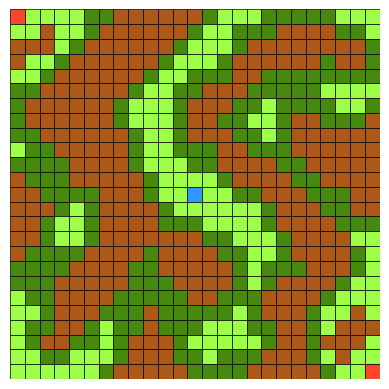

In [2]:
map.visualize_map()

## Policy Evaluation

Consider a policy $\pi(a|s)$. The goal of policy evaluation is to find the value function $v_\pi(s)$ for all $s \in S$ under this policy. Recall that the value function $v_\pi(s)$ is the expected discounted return if the agent starts at state $s$ and then follows policy $\pi$.

$$
v_\pi(s) \text{ } \dot{=} \text{ } \mathbb{E}\{G_{t} | S_t = s\}
$$

We can approximate $v_\pi(s)$ using the iterative policy evaluation algorithm, which employs the expected update rule derived from the Bellman equation:

$$
V_{k+1}(s) \text{ } \dot{=} \text{ } \sum_a \pi(a|s) \sum_{s^\prime, r} p(s^\prime, r \mid s, a) [r + \gamma V_k(s^\prime)]
$$

Here, the initial approximation $v_0(s)$ is chosen arbitrarily. As $k$ approaches infinity, $v_k(s)$ approximates $v_\pi(s)$. In this problem, $p(s^\prime, r \mid s, a) = 1$ for all $a \in A, s \in S$, since each action $a$ from state $s$ leads to a specific next state $s^\prime$ and reward $r$. Additionally, as this is an episodic task, $\gamma = 1$. Therefore, the expression simplifies to:

$$
V_{k+1}(s) = \sum_a \pi(a|s) [r + V_k(s^\prime)]
$$

The Remote Island Journey is a finite Markov decision problem, with $\mathcal{S}$, $\mathcal{A}$, and $\mathcal{R}$ having finite elements. We can define the value function $v(s)$ as a vector $V \in \mathbb{R}^{|\mathcal{S}|}$, where $V_i$ represents the policy evaluation at state $i$. The policy can be defined as a matrix $P \in \mathbb{R}^{|\mathcal{A}| \times |\mathcal{S}|}$, where $P_{ij}$ is the probability of the agent taking action $i$ in state $j$, ensuring $\sum_i P_{ij} = 1$ for all $j$.

The `bellman_update()` function implements the update rule, and the `iterative_policy_evaluation()` function performs the policy evaluation until $\max_{s} |V_{k} - V_{k+1}|$ is below a given threshold:

In [3]:
def bellman_update(V, s, pi, env):
    new_v = 0
    for a in env.A:
        sp, r = env.step(s, a)
        new_v += pi[a][s] * (r + V[sp])
    V[s] = new_v 

def iterative_policy_evaluation(pi, env, threshold=1e-5):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            old_vs = V[s] 
            bellman_update(V, s, pi, env)
            new_vs = V[s]
            delta = max(delta, abs(old_vs - new_vs))
        if delta < threshold:
            return V

Let's start by creating a policy $\pi(a|s) = \frac{1}{|\mathcal{A}|}$ and computing its value function $v_\pi(s)$:

In [4]:
pi = np.ones((len(env.A), len(env.S))) / len(env.A)

We can ensure that $\sum_a \pi(a|s) = 1$ for all $s \in \mathcal{S}$:

In [5]:
np.all(np.sum(pi, axis=0) == 1)

True

Now, we evaluate this policy using the iterative policy evaluation algorithm:

In [6]:
# V = iterative_policy_evaluation(pi, env=env)
# V.shape

And visualize the value function for each state on the map:

In [7]:
# map.visualize_value_function(V)

Next, we implement a function to determine the action to follow in each state of the map:

In [8]:
def get_actions(pi, env):
    actions = []
    for s in env.S:
        actions.append(np.random.choice(env.A, p=pi[:, s]))
    return actions

Then, we can visualize these actions on the map:

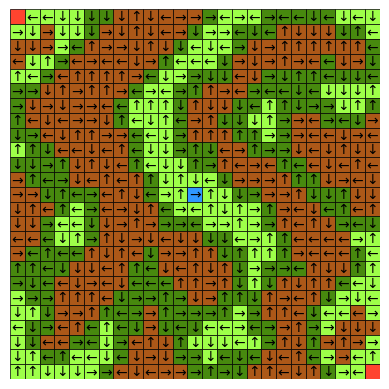

In [9]:
map.visualize_actions(actions=get_actions(pi, env))

## Value Iteration

Value iteration is an alternative to policy iteration that avoids the need for a full policy evaluation step. Instead, it updates the value function directly using the Bellman optimality equation, combining policy improvement and truncated policy evaluation in a single step.

The update rule for value iteration is:

$$
V_{k+1}(s) \text{ } \dot{=} \text{ } \max_{a} \sum_{s^\prime, r} p(s^\prime, r \mid s, a) [r + \gamma V_k(s^\prime)]
$$

Here, $V_{k+1}(s)$ is updated by taking the maximum expected return over all possible actions $a$ from state $s$. This rule essentially performs one sweep of policy evaluation followed by policy improvement, thus iteratively improving the value function $V(s)$. Given an initial arbitrary value function $V_0(s)$, the sequence $\{V_k(s)\}$ can be shown to converge to the optimal value function $v^*(s)$.

Just as before, we can simplify this equation considering that $p(s^\prime, r \mid s, a) = 1$ for all $a \in A, s \in S$, and that $\gamma = 1$:

$$
V_{k+1}(s) \text{ } = \text{ } \max_{a} [r + V_k(s^\prime)]
$$

Below is the algorithm implementation:

In [18]:
def greedy_update(V, s, env):
    new_v = float("-inf")
    for a in env.A:
        sp, r = env.step(s, a)
        v = r + V[sp]
        if v > new_v:
            new_v = v
    V[s] = new_v 

def value_iteration(env, threshold=1e-5):
    V = np.ones(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            old_vs = V[s] 
            greedy_update(V, s, env)
            new_vs = V[s]
            delta = np.max([delta, np.abs(old_vs - new_vs)])
        if delta < threshold:
            return V

Once we approximate the optimal value function $V(s) \approx v^*(s)$, it is relatively easy to determine an optimal policy. For each state $s$, there will be one action at which the maximum is obtained in the Bellman optimality equation. Any policy that assigns nonzero probability only to this action is an optimal policy:

$$
\pi^*(a|s) = \begin{cases} 
      1 & \text{if } a = \argmax_a [r + v^*(s^\prime)]\\
      0 & \text{otherwise}
\end{cases}
$$

In [11]:
def get_policy(optimal_V, env):
    pi = np.zeros((len(env.A), len(env.S)))
    for s in env.S:
        optimal_a = None
        new_v = float("-inf")
        for a in env.A:
            sp, r = env.step(s, a)
            v = r + optimal_V[sp]
            if v > new_v:
                new_v = v
                optimal_a = a 
        pi[optimal_a][s] = 1
    return pi

To find the optimal value function and corresponding policy, we use the `value_iteration` function and then derive the policy from it:

In [19]:
optimal_V = value_iteration(env)
optimal_pi = get_policy(optimal_V, env)

With the optimal value function  and policy computed, we can visualize the results to understand the optimal path and decision-making process better.

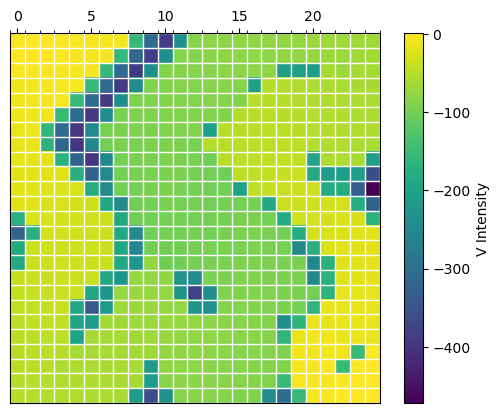

In [15]:
map.visualize_value_function(optimal_V)

Next, we visualize the actions suggested by the optimal policy for each state:

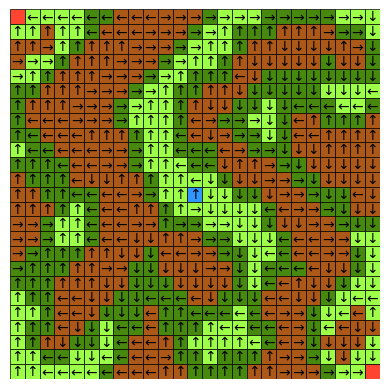

In [16]:
map.visualize_actions(actions=get_actions(optimal_pi, env))

This visualization shows arrows indicating the optimal actions from each state, guiding the explorer towards the endpoint efficiently.

Finally, we can visualize the actual path taken by the explorer following the optimal policy:

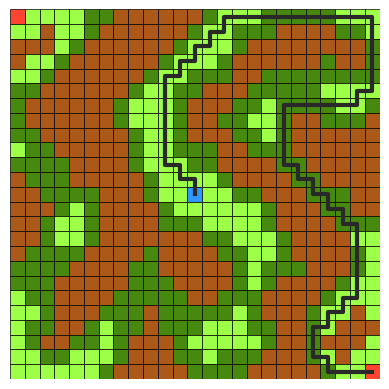

In [17]:
map.visualize_path(actions=get_actions(optimal_pi, env))